In [2]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

from pathlib import Path
from analysis import collection, analysis
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

## For each target: 
- compute average correlation between (normalized) task-space decoder axes and target vector
- now you have 12 correlations for each subject
- for each target, across subjects, how well does that decoder correlation predict performance per target?
- plot = subjects' total performance (hits) per target vs. decoder corr for that target -- plot all targets together? (color-coded?)

### how are the offsets and variance calculated?

offsets -- extract quiescent periods before movement cue is given, filter these and take the mean. this is then subtracted from the "live" signal as a shift.

variance -- this is computed per channel from the calibration bars dataset, divided per channel as a whitening

## get decoders

In [3]:
c = collection.Collection("emg_olympics")
subjects = c.alphabetically_sorted_subjects()
decoders = {}
for s in subjects:
    decoders[s.name] = s.decoder[-2:,:]

## plot decoder directions in task space

/Users/spencer/phd/phd/analysis/notebooks/../analysis/analysis.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.cos(theta), np.sin(theta), style, marker=m, markersize=markersize, color="grey")
/Users/spencer/phd/phd/analysis/notebooks/../analysis/analysis.py:93: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.cos(theta), np.sin(theta), style, marker=m, markersize=markersize, color="grey")


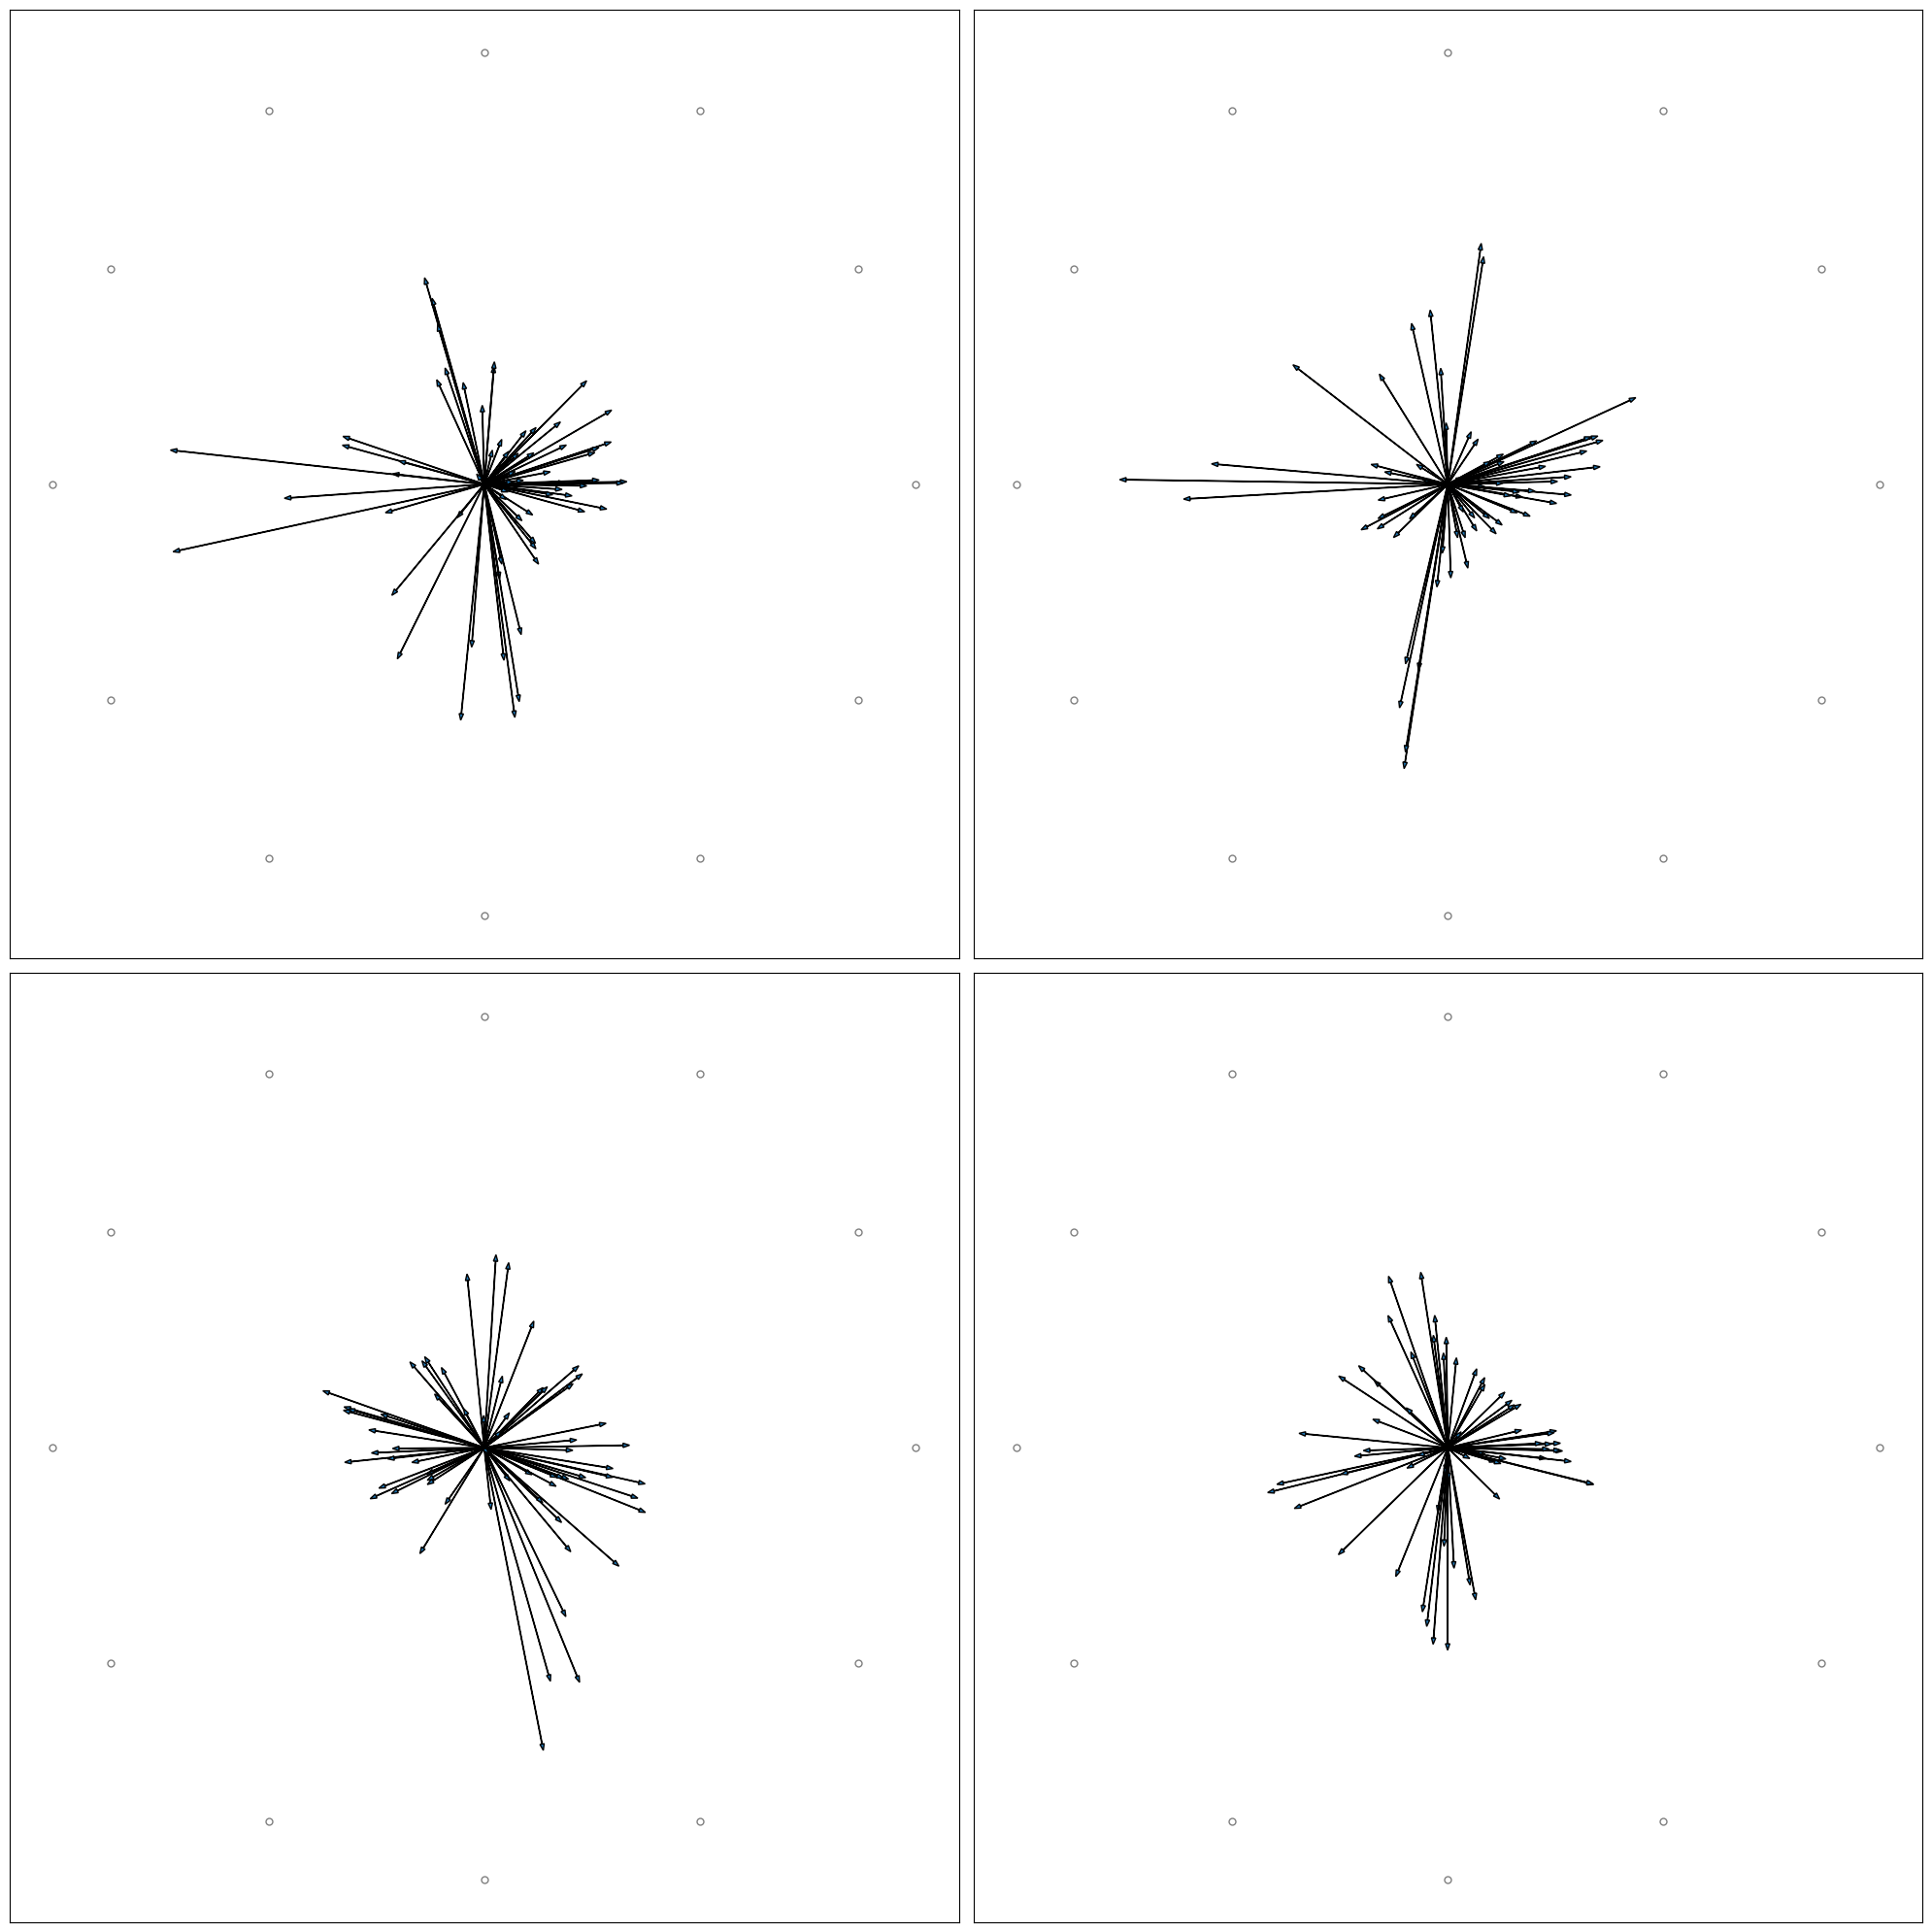

In [4]:
def plot_decoder_arrows(decoder, ax):
    analysis.plot_targets(ax)
    # plot x and y components of the decoder
    for col in decoder[-2:,:].T:
        ax.arrow(0,0,col[0],col[1],head_width=.01)


decoder_arrow_fig, axes = plt.subplots(2,2,figsize=(20,20))
example_subjects = [[4, 12], [28, 37]]
subject_names = c.subject_names
plot_decoder_arrows(decoders[subject_names[example_subjects[0][0]]], axes[0][0])
plot_decoder_arrows(decoders[subject_names[example_subjects[0][1]]], axes[0][1])
plot_decoder_arrows(decoders[subject_names[example_subjects[1][0]]], axes[1][0])
plot_decoder_arrows(decoders[subject_names[example_subjects[1][1]]], axes[1][1])
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
decoder_arrow_fig.tight_layout()

In [5]:
decoder_arrow_fig.savefig(image_path / "analysis/example_decoder_arrows.pdf", dpi=300, format="pdf")

## decoder-target mean cosine distance per target

[-0.87, -0.5] 8
8


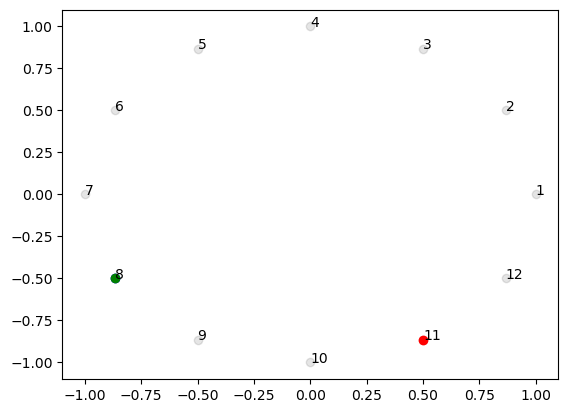

In [5]:
# array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

# target number is counted from [1,0] counterclockwise, in order of increasing theta

trial = c.alphabetically_sorted_subjects()[0].tasks["center_hold"].sorted_sessions()[0].sorted_trials()[10]

i = 1
for a in collection.generate_target_angles():
    plt.plot(np.cos(a), np.sin(a), "ko", alpha=0.1)
    plt.annotate(i, (np.cos(a), np.sin(a)))
    i+=1

theta = collection.compute_theta(collection.compute_target_vec_from_number(11))
plt.plot(np.cos(theta), np.sin(theta), "ro")

print(trial.target_coords, trial.target_number)
print(collection.compute_target_number_from_vec(trial.target_coords))

theta2 = collection.compute_theta(trial.target_coords)
plt.plot(np.cos(theta2), np.sin(theta2), "bo")

theta3 = collection.compute_theta(collection.compute_target_vec_from_number(collection.compute_target_number_from_vec(trial.target_coords)))
plt.plot(np.cos(theta3), np.sin(theta3), "go")


In [82]:
def compute_decoder_target_cosine(decoder, target_vector):
        # compute the cosine distance between target direction and decoder direction 
        # decoder : 64x2 64 - x,y 
        # target_vector: 2x1 (x,y)
        dotprod = np.dot(decoder,target_vector).reshape(64,1) # 64
        norm_target = np.linalg.norm(target_vector) # 1
        norm_decoder_directions = np.linalg.norm(decoder, axis=1).reshape(64,1) # 64
        # cos = 1 - abs(dot(a,b) / (norm(a)*norm(b)))
        # orthogonal --> 90deg, dot=0 --> 1 
        # parallel --> 0deg, dot=1 --> 0

        return np.divide(dotprod, (norm_target*norm_decoder_directions))

def compute_decoder_target_projection(decoder, target_vector):
        # compute the cosine distance between target direction and decoder direction 
        # decoder : 64x2 64 - x,y 
        # target_vector: 2x1 (x,y)
        return np.dot(decoder,target_vector).reshape(64,1) # 64

def generate_target_coords():
    coords = {}
    for i, angle in enumerate(collection.generate_target_angles()):
        coords[i+1] = [np.cos(angle), np.sin(angle)]
    return coords

(64, 1)


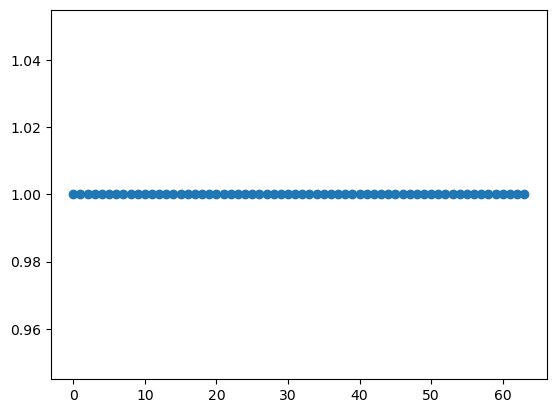

In [83]:
x = np.vstack([range(1,65),range(1,65)]).T*0.1
y = np.ones(shape=(2,1))
z = compute_decoder_target_cosine(x,y)
print(z.shape)
plt.plot(z,"o")

In [84]:
mean_cosine_vec = np.empty((len(c.alphabetically_sorted_subjects()),12))
# for each subject
for subject_number, s in enumerate(c.alphabetically_sorted_subjects()):
    # get the decoder
    decoder = s.decoder[-2:,:].T # 64x2
    # for each target vector
    for target_number, target_vector in generate_target_coords().items():
        cosine = compute_decoder_target_cosine(decoder, target_vector)
        # compute the mean of the cosine distances
        mean_cosine_vec[subject_number][target_number-1] = np.mean(cosine)

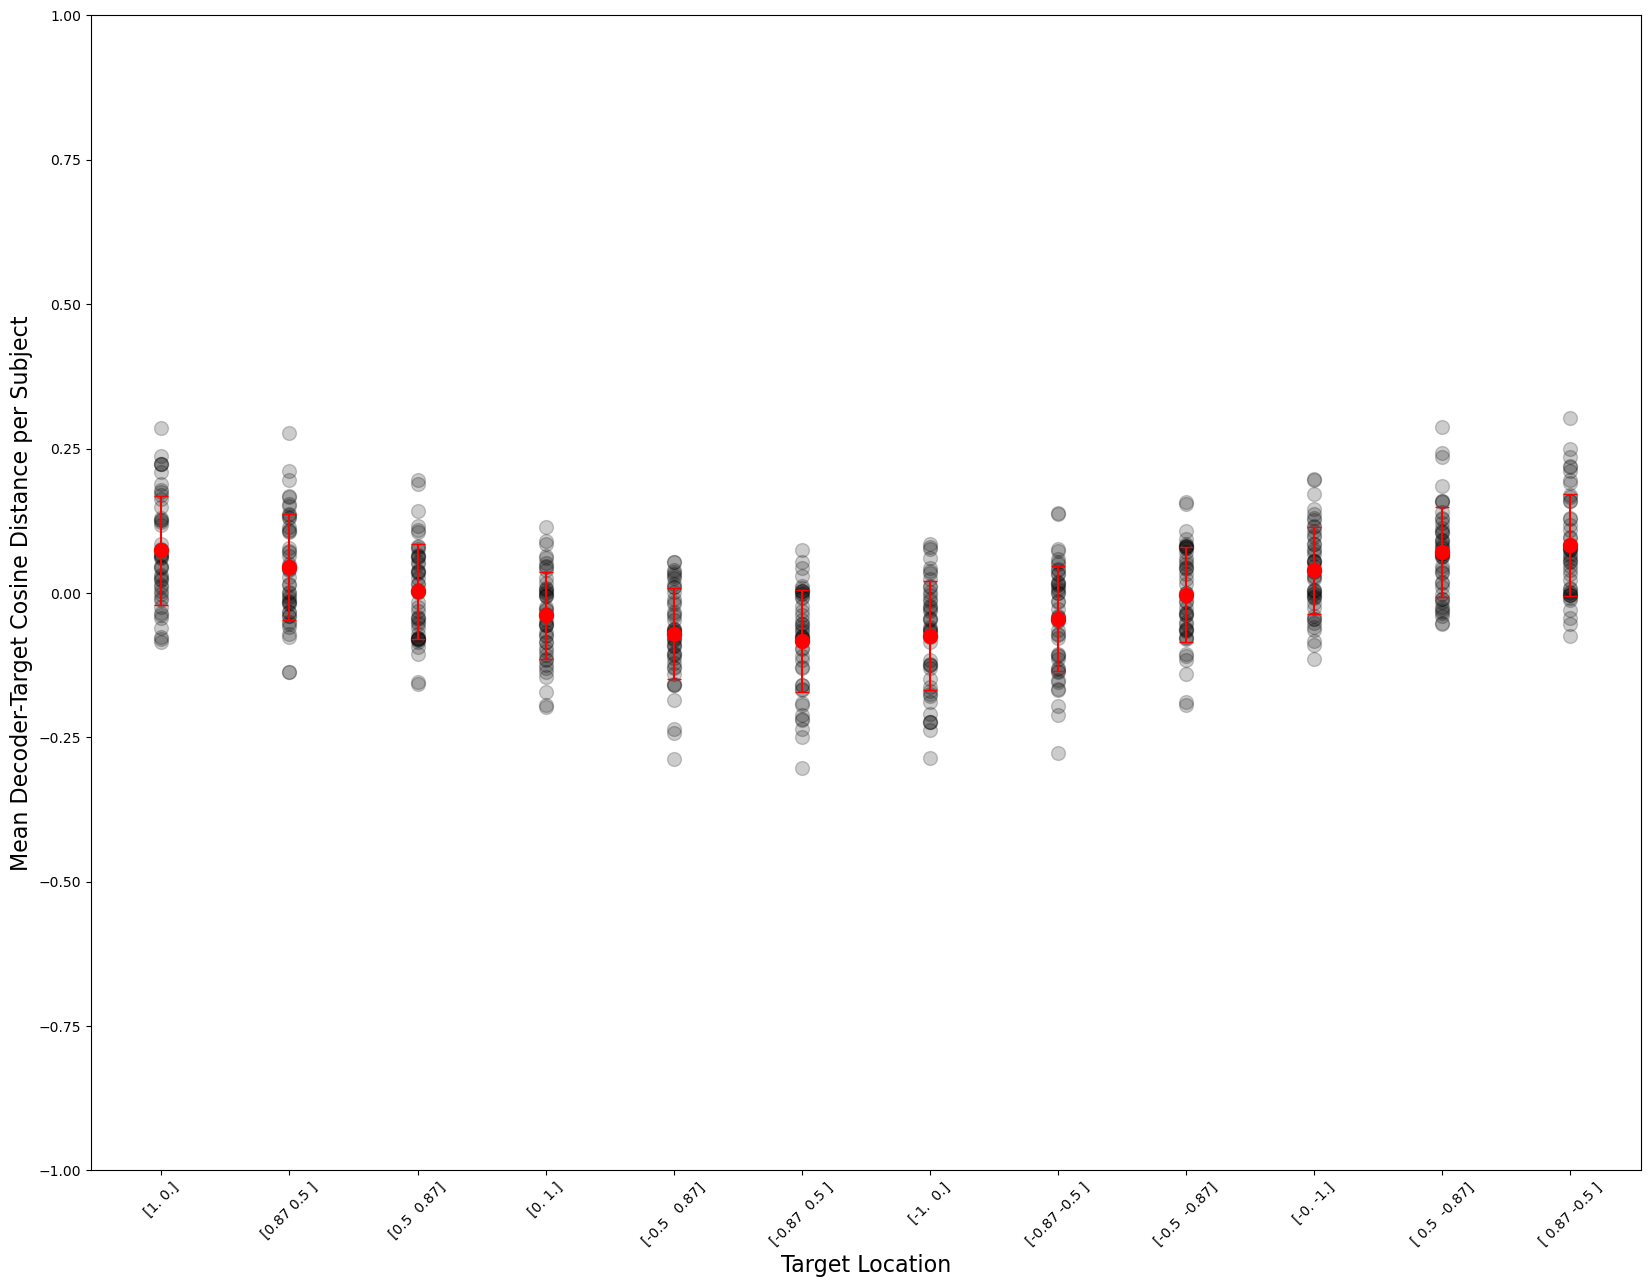

In [86]:
fig, ax = plt.subplots(1,1,figsize=(20,15))

for target_idx, subject_cosine_means in enumerate(mean_cosine_vec.T):
    x = target_idx*np.ones(subject_cosine_means.shape[0])
    ax.plot(x, subject_cosine_means[:], "ko", alpha=0.2, markersize=10)
    ax.errorbar(x[0], np.mean(subject_cosine_means[:]), np.std(subject_cosine_means[:]), color="r", capsize=5)
    ax.plot(x[0], np.mean(subject_cosine_means[:]),"ro", markersize=10)
ax.set_ylim([-1,1])
ax.set_xlabel("Target Location")
ax.set_ylabel("Mean Decoder-Target Cosine Distance per Subject")
_ = ax.set_xticks(range(12), labels=[str(collection.compute_target_vec_from_number(tn)) for tn in range(1,13)], rotation=45)


In [15]:
fig.savefig(image_path / "analysis/decoder_target_cosine.pdf", dpi=300, format="pdf")

## hit counts per target

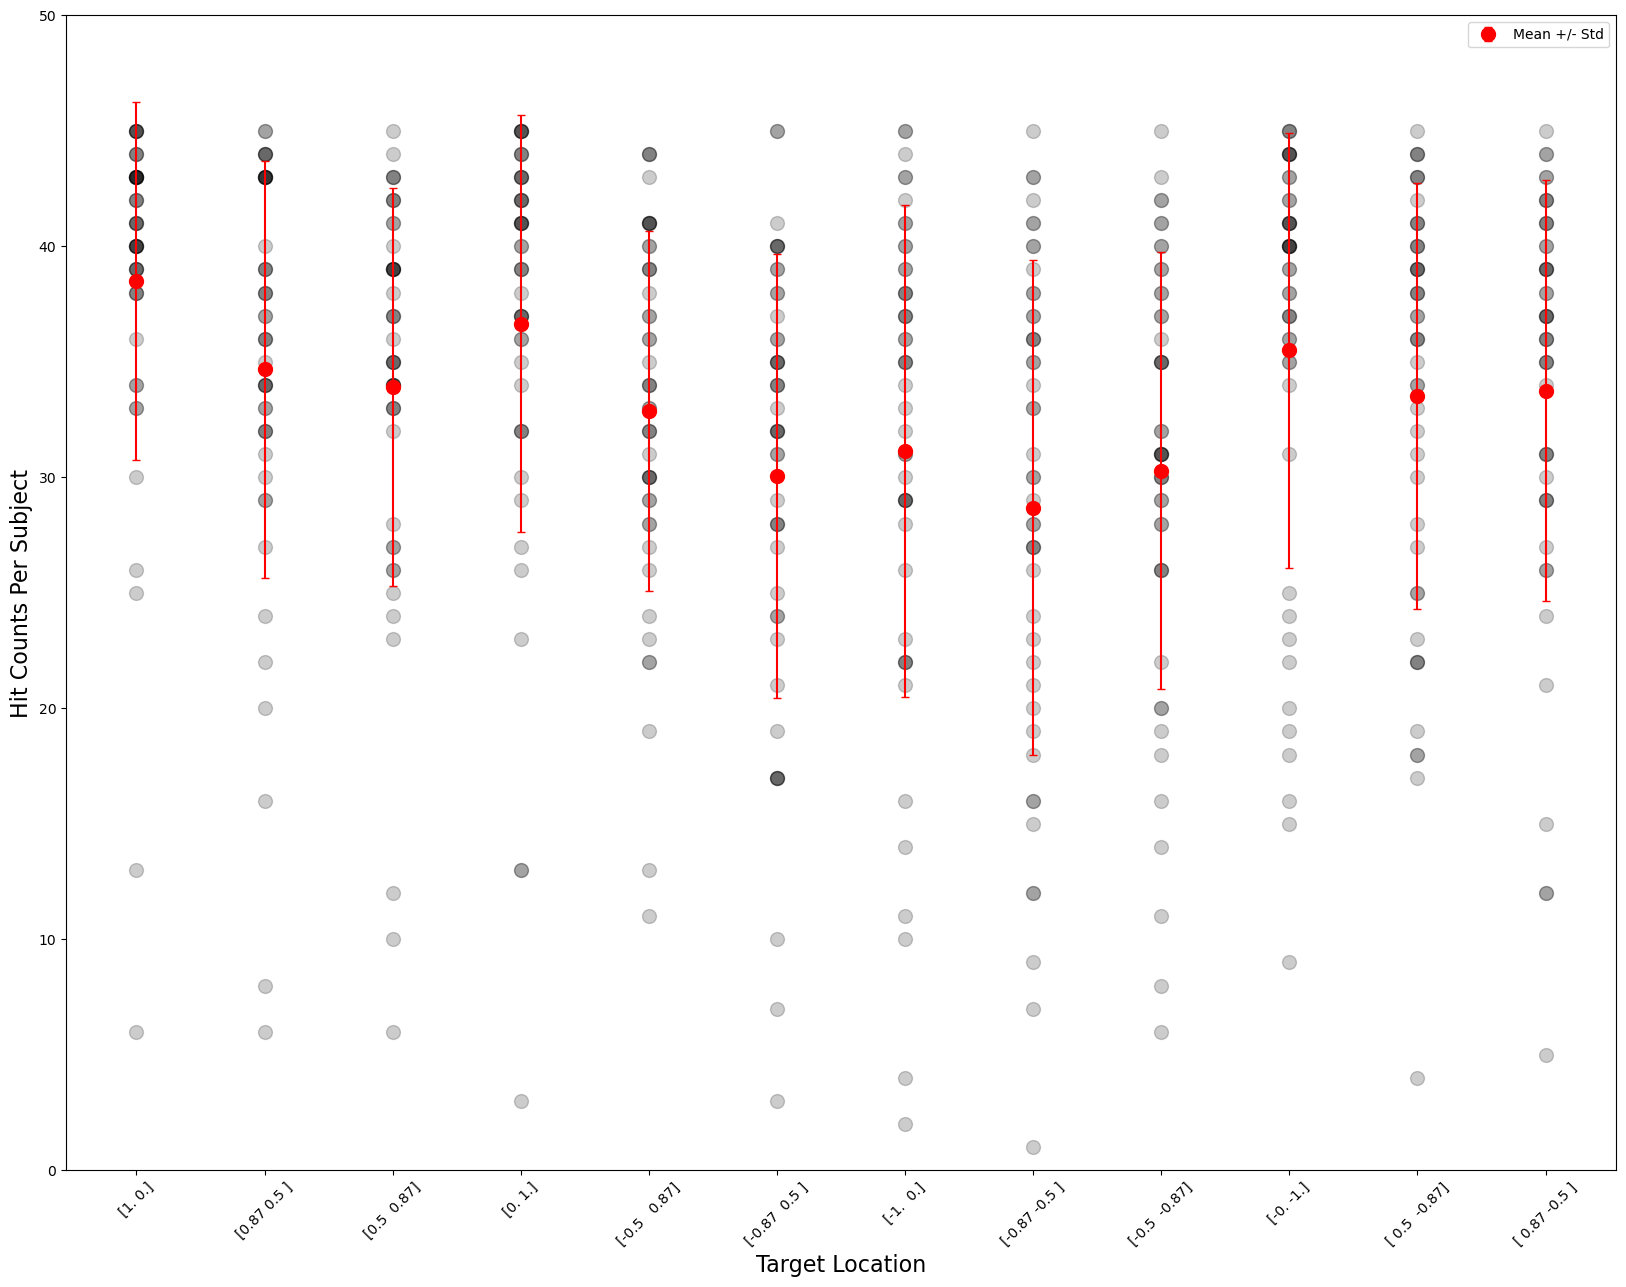

In [16]:

hit_count_vec = np.zeros(shape=(len(c.alphabetically_sorted_subjects()),12))
for subject_idx, subject in enumerate(c.alphabetically_sorted_subjects()):
    sessions  = subject.tasks["center_hold"].sorted_sessions()
    # for every trial, add up hits for each target
    for sesh in sessions:
        trials = sesh.sorted_trials()
        for trial in trials:
            if trial.outcome == "Hit":
                # subject, target_index
                hit_count_vec[subject_idx][trial.target_number-1] += 1

fig, ax = plt.subplots(1,1,figsize=(20,15))
for target_idx, target_hc in enumerate(hit_count_vec.T):
    ax.plot(np.ones(len(target_hc))*(target_idx), target_hc, 'ko', alpha=0.2, markersize=10)

x = list(range(12))
means = np.mean(hit_count_vec, axis=0)
stds = np.std(hit_count_vec, axis=0)
ax.errorbar(x, means, stds, linestyle='None', marker='o', markersize=10, capsize=3, label="Mean +/- Std", color="red")

ax.set_xticks(x, labels=[str(collection.compute_target_vec_from_number(xx+1)) for xx in x], rotation=45)
ax.set_ylabel("Hit Counts Per Subject") 
ax.set_ylim([0,50])
ax.set_xlabel("Target Location")
ax.legend()

In [11]:
fig.savefig(image_path / "analysis/hits_over_targets.pdf", dpi=300, format="pdf")

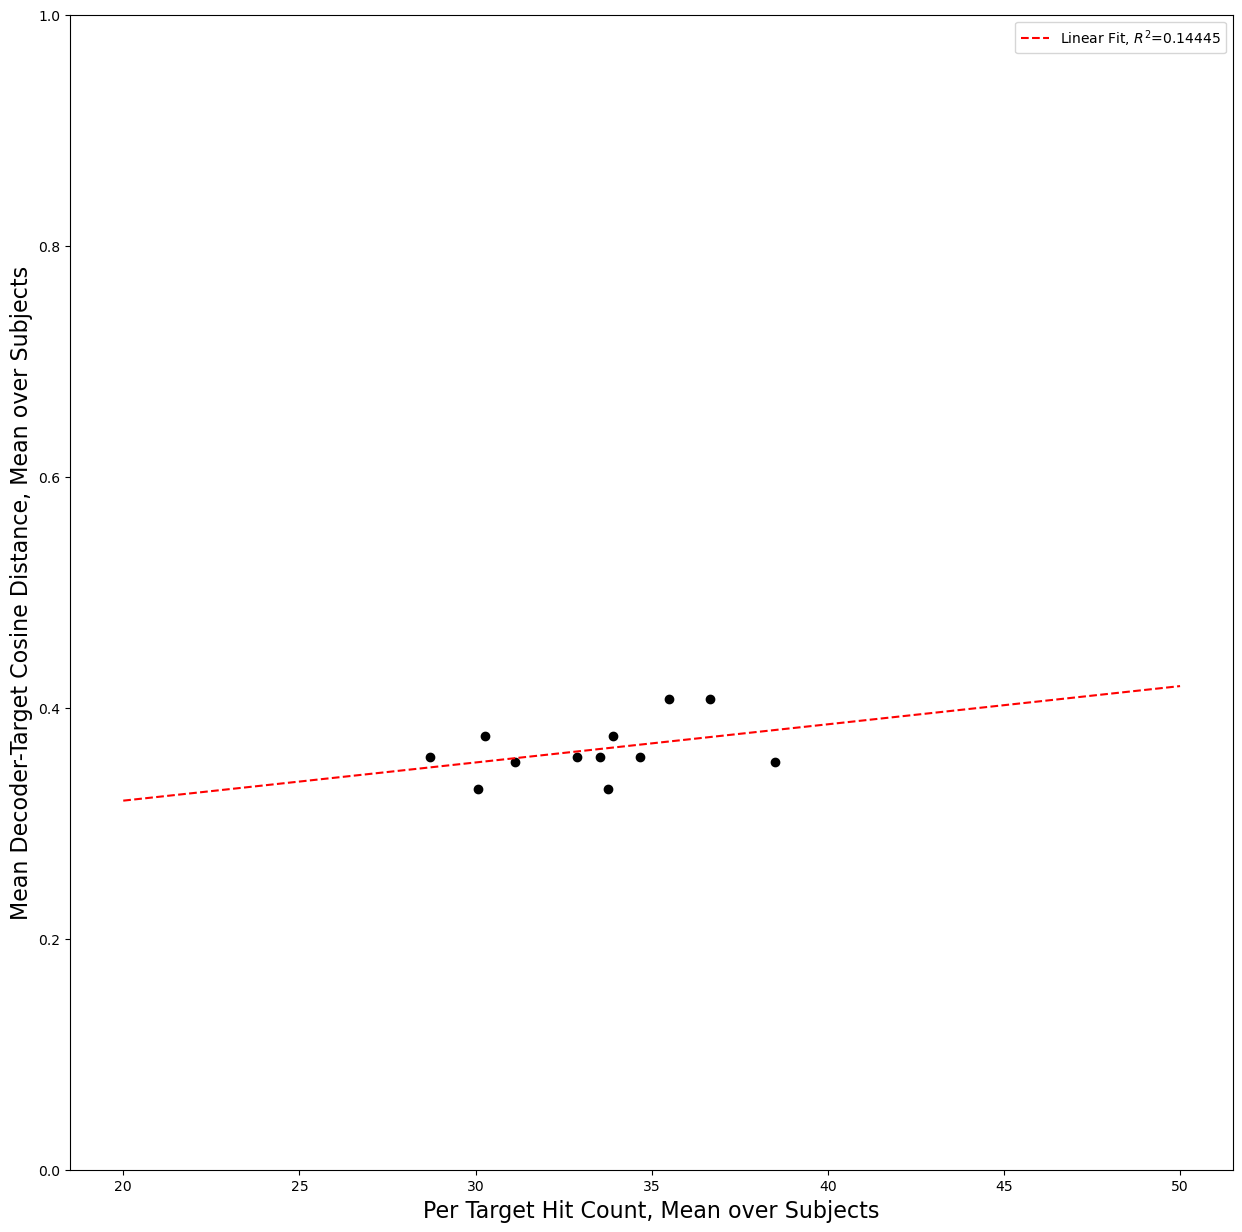

In [17]:
# plot just the means

fig, ax = plt.subplots(1,1,figsize=(15,15))

hc_means = np.mean(hit_count_vec, axis=0)
mc_means = np.mean(mean_cosine_vec, axis=0)
for x,y in zip(hc_means, mc_means):
    ax.plot(x,y,"ko")

result = linregress(hc_means, mc_means)
x = np.linspace(20,50,100)
ax.plot(x, result.intercept + result.slope*x,"r--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2,5)}")
ax.set_xlabel("Per Target Hit Count, Mean over Subjects")
ax.set_ylabel("Mean Decoder-Target Cosine Distance, Mean over Subjects")
ax.set_ylim([0,1])
ax.legend()

In [ ]:
fig.savefig(image_path / "analysis/decoder_target_cosine_vs_hits_subject_mean.pdf", dpi=300, format="pdf")

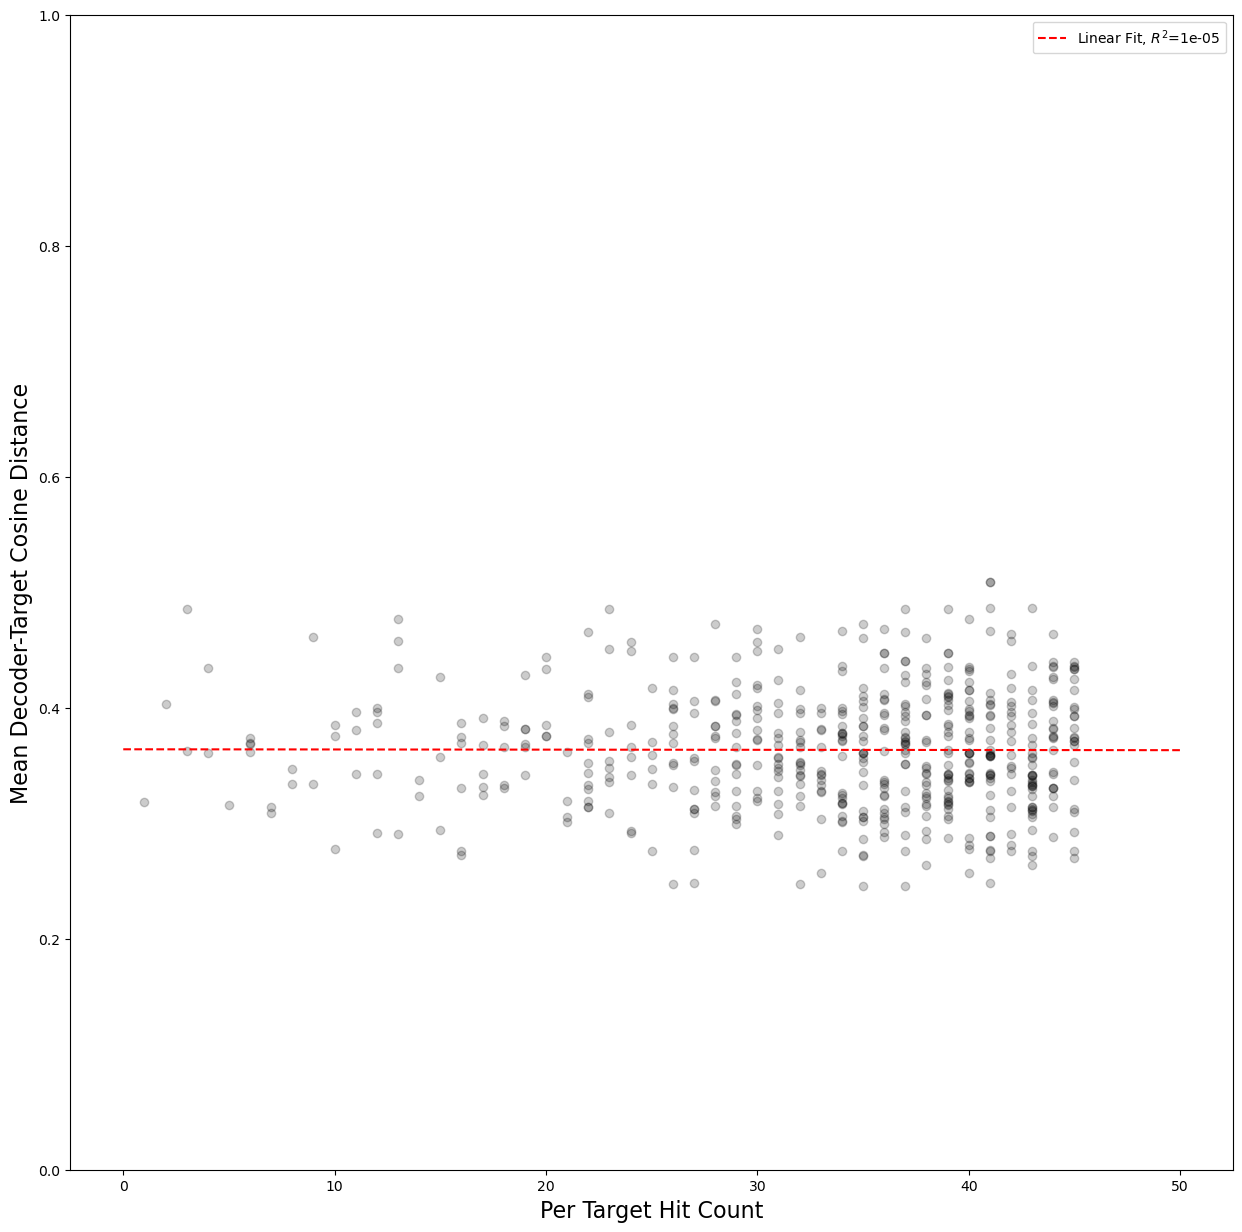

In [18]:

fig, ax = plt.subplots(1,1,figsize=(15,15))

for x,y in zip(hit_count_vec.ravel(), mean_cosine_vec.ravel()):
    ax.plot(x,y,"ko",alpha=0.2)

result = linregress(hit_count_vec.ravel(), mean_cosine_vec.ravel())
x = np.linspace(0,50,100)
ax.plot(x, result.intercept + result.slope*x,"r--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2,5)}")
ax.set_xlabel("Per Target Hit Count")
ax.set_ylabel("Mean Decoder-Target Cosine Distance")
ax.set_ylim([0,1])
ax.legend()

In [ ]:
fig.savefig(image_path / "analysis/decoder_target_cosine_vs_hits.pdf", dpi=300, format="pdf")

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

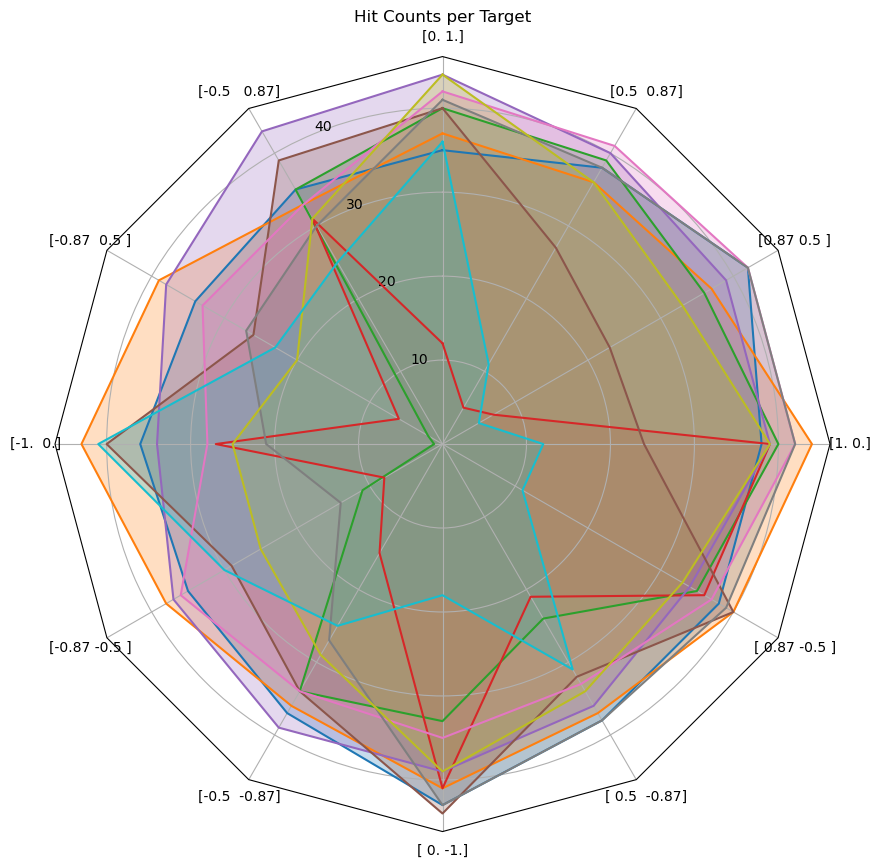

In [ ]:
data = []
hit_counts = {}
for subject in c.alphabetically_sorted_subjects():
    sessions  = subject.tasks["center_hold"].sorted_sessions()
    hit_counts_per_target = {}
    for sesh in sessions:
        trials = sesh.sorted_trials()
        for trial in trials:
            # get outcome
            oc = trial.outcome
            # add 0 to get around weird negative 0 thing for later comparison
            tc = np.round(np.array(trial.target_coords),2) + 0.0
            if oc == "Hit":
                # get target location
                try:
                    current_count = hit_counts_per_target[str(np.array(tc))][1]
                    hit_counts_per_target[str(tc)] = (tc, current_count + 1)
                except KeyError:
                    hit_counts_per_target[str(tc)] = (tc, 0)
    hit_counts[subject.name] = hit_counts_per_target
    target_names = []
    counts = []
    # sort by theta angle
    for name, (coord, count) in sorted(hit_counts_per_target.items(), key=lambda s: np.arctan2(s[1][0][1],s[1][0][0])):
        target_names.append(name)
        counts.append(count)
    data.append(counts)


N = len(target_names)
theta = radar_factory(N, frame='polygon')

# roll these around to line up with plot coordinates
rollby=-8
spoke_labels = np.roll(np.array(target_names), rollby)
title = "Hit Counts per Target"

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([10, 20, 30, 40, 50, 60])
ax.set_title(title,  position=(0.5, 1.1), ha='center')

for d in data[-10:]:
    d = np.roll(np.array(d), rollby)
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.25)
ax.set_varlabels(spoke_labels)